In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api
import matplotlib.pyplot as plt

In [2]:
# Load the data
data = pd.read_csv(r"..\cleaned_datasets\fullData.csv")

# Subset to interesting columns
keepVars = [
    'bctcb2020', 'shape_area', 'modzcta', 'boroname',
    'numGrocery', 'numRestaurant', 'numSubway',
    'numCrime', 'numViolent',
    'No Internet Access (Percentage of Households)'
]
data = data[keepVars]
data = data.rename({'No Internet Access (Percentage of Households)':'percNoInternet'}, axis='columns')

In [3]:
# Attach price per zip
priceData = pd.read_csv(r"..\cleaned_datasets\price_per_zip.csv")
data = data.merge(
    priceData,
    on='modzcta'
)

In [4]:
# Normalize count by area
data = data.assign(groc_per_area = (data['numGrocery'] / data['shape_area']))
data = data.assign(rest_per_area = (data['numRestaurant'] / data['shape_area']))
data = data.assign(subw_per_area = (data['numSubway'] / data['shape_area']))
data = data.assign(crim_per_area = (data['numCrime'] / data['shape_area']))
data = data.assign(viol_per_area = (data['numViolent'] / data['shape_area']))

In [5]:
# Final dataset
keepVars = [
    'price_per_sqft',
    'groc_per_area', 'rest_per_area', 'subw_per_area',
    'crim_per_area', 'viol_per_area',
    'percNoInternet',
    'bctcb2020', 'boroname', 'modzcta'
]
data = data[keepVars]
data.describe()

,price_per_sqft,groc_per_area,rest_per_area,subw_per_area,crim_per_area,viol_per_area,percNoInternet,bctcb2020,modzcta
count,24895.000000,24895.000000,24895.000000,24895.000000,24895.000000,24895.000000,24895.000000,2.489500e+04,24895.000000
mean,546.935967,0.000220,0.001645,0.000027,0.000080,0.000027,0.168600,3.599232e+10,11014.850291
std,161.265211,0.000586,0.006228,0.000084,0.000336,0.000107,0.050974,9.576229e+09,451.550938
min,261.437908,0.000000,0.000000,0.000000,0.000000,0.000000,0.035500,1.010602e+10,10021.000000
25%,429.194929,0.000030,0.000344,0.000000,0.000006,0.000000,0.131800,3.030700e+10,10465.000000
50%,554.667441,0.000097,0.000769,0.000008,0.000027,0.000006,0.156000,4.020500e+10,11221.000000
75%,642.229110,0.000228,0.001567,0.000029,0.000075,0.000026,0.198950,4.100804e+10,11373.000000
max,1592.193011,0.055690,0.808530,0.008250,0.025903,0.010222,0.323600,5.032300e+10,11694.000000


In [6]:
# Check correlation between predictors
# Multicollinearity can invalidate linear model
data[['groc_per_area','rest_per_area','subw_per_area','viol_per_area','percNoInternet']].corr()

,groc_per_area,rest_per_area,subw_per_area,viol_per_area,percNoInternet
groc_per_area,1.000000,0.884388,0.917664,0.127277,0.170822
rest_per_area,0.884388,1.000000,0.851092,0.057410,0.033606
subw_per_area,0.917664,0.851092,1.000000,0.099431,0.122109
viol_per_area,0.127277,0.057410,0.099431,1.000000,0.153741
percNoInternet,0.170822,0.033606,0.122109,0.153741,1.000000


In [7]:
# Only keep subways because there is strong collinearity in grocery, restaurants, and subways
# Assumes that the grocery stores and restaurants are located with respect to subways

# Create a multilevel model to predict price per square foot
# Since housing prices are often log-normal, do a log transform on y
# Add a random intercept for the borough that each block is in
model = smf.mixedlm(
    "np.log(price_per_sqft) ~ subw_per_area + viol_per_area + percNoInternet", 
    data, 
    groups=data['boroname']
)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:            MixedLM Dependent Variable: np.log(price_per_sqft)
No. Observations: 24895   Method:             REML                  
No. Groups:       5       Scale:              0.0268                
Min. group size:  120     Log-Likelihood:     9714.2026             
Max. group size:  10012   Converged:          Yes                   
Mean group size:  4979.0                                            
--------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------------
Intercept             6.261    0.226  27.668 0.000    5.818    6.705
subw_per_area      -140.493   12.692 -11.069 0.000 -165.369 -115.617
viol_per_area        -4.670    9.862  -0.474 0.636  -23.999   14.658
percNoInternet        0.809    0.024  33.266 0.000    0.762    0.857
Group Var             0.256    1.023                                
====================================================================

"""

In [8]:
# From the model summary:
# There are differences between boroughs, but not enough to matter (Std.Err.)
# Increasing subway access decreases price on average
# Increasing violent crime prevalence decreases price on average, but not enough to matter (Std.Err.)
# Increasing percent of households without internet increases price on average
#
# My suspicion is that this comes down to exclusivity: More subway access means
# that you are in a more central area, which is less exclusive, which is less desirable.
# Additionally, if you can afford to be away from a subway, you probably get around the city
# using other kinds of transportation. I think this is also why as fewer households have internet
# the price also increases. Infrastructure is centralized.

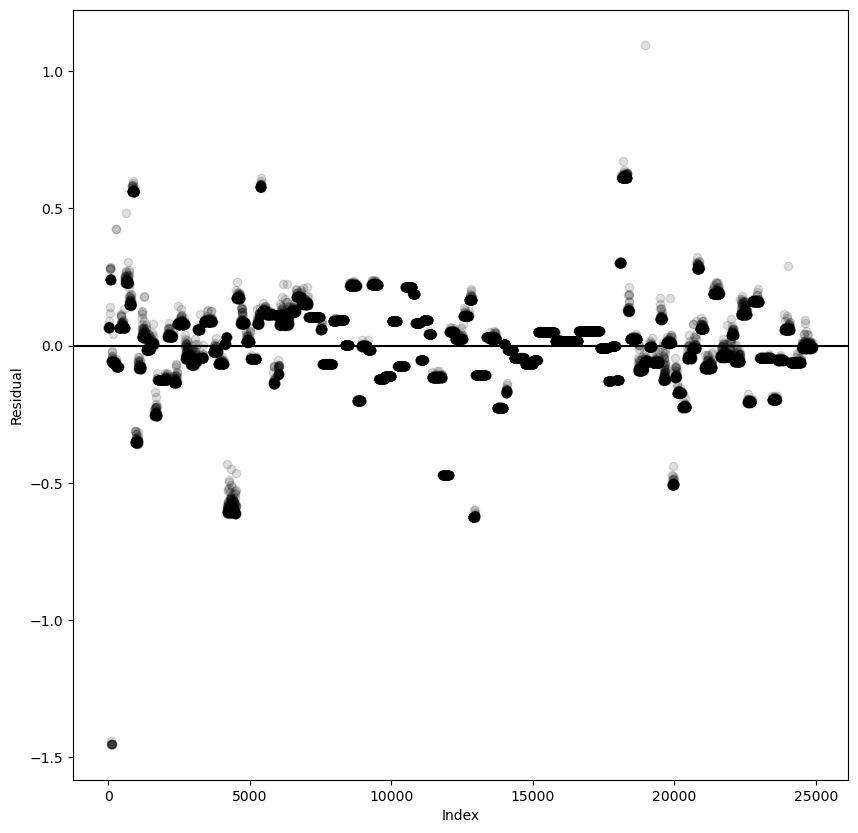

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(
    x=range(0, data.shape[0]),
    y=model.resid,
    c="#00000020"
)
ax.axline((0, 0), slope=0, color='#000000')
ax.set(xlabel = 'Index', ylabel='Residual')
plt.show()

In [10]:
# Residual plot is used to check for violations in the error assumptions for regression.
# What I notice mostly is that lots of the points are centered together. This is probably
# because the price per square foot is calculated at the zip code level, but the observations
# are at the block level. Just a limitation.
#
# Violation-wise, it looks mostly okay. I'm not seeing anything that looks like the residuals
# are abnormal.

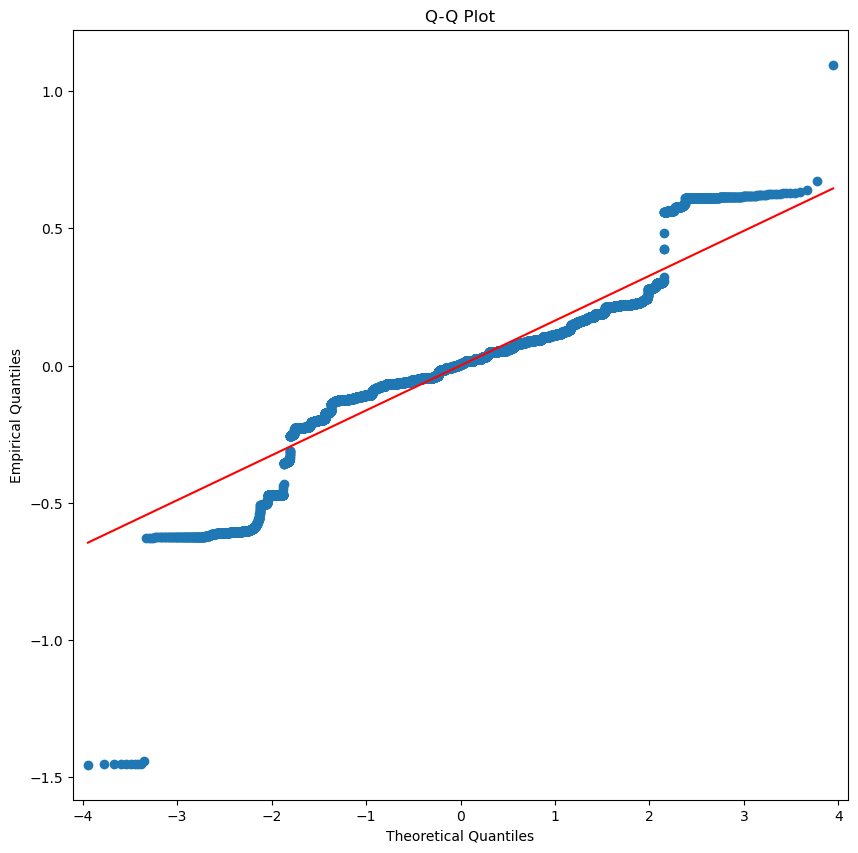

In [11]:
# Q-Q plot
fig, ax = plt.subplots(figsize=(10,10))
statsmodels.api.qqplot(model.resid, line='s', ax=ax)
ax.set(xlabel = 'Theoretical Quantiles', ylabel='Empirical Quantiles')
ax.set_title("Q-Q Plot")
plt.show()

In [12]:
# The Q-Q plot is for checking if the residuals are normally distributed.
# If they are, they would all fall on the red line, which is not happening here.
# This implies that the model is not capturing the true price per square foot of
# blocks that are at the far edges (low and high prices), but does okay in the middle.
# We might interpret this like as saying that exclusivity makes more sense for medium desirable areas,
# but that the most expensive and most cheap are drived by other (maybe social) factors that aren't
# in this model.

In [13]:
# Calculate the predicted change in price per square foot assuming you go from
# the least amount to the most amount (as found in our data).
#
# Interpret like this:
# "Assuming all else equal, the block with the most subway access per area 
# is associated with a 68.6% decrease in price on average compared to the 
# block with the lease subway access."
#
# Note: The percent interpretation only happens because the model predicts the 
# price per square foot on the log scale.

# Subway
# Decrease by ~68.6%
print(100 * (np.exp(-140.493 * (0.008250 - 0.000000)) - 1) )

# Violence
# Decrease by ~4.7%
print(100 * (np.exp(-4.670 * (0.010222 - 0.000000)) - 1))

# Percent No Internet
# Increase by ~26.2%
print(100 * (np.exp(0.809 * (0.323600 - 0.035500)) - 1)) 

-68.62212784697417
-4.661525788994769
26.247351029159226
